# Project №4: The Computer Says "No"

The aim of the project is to write a scoring model for predicting the default of bank customers.

Importing Libraries

In [256]:

import numpy as np 
import pandas as pd 

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFpr, SelectFdr, SelectFwe
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV


from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer




from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import datetime 
from datetime import datetime, timedelta


from sklearn.svm import LinearSVC
from sklearn.svm import SVC


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [164]:
RANDOM_SEED = 42

Load train and test datasets

In [165]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [166]:
data_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Basic data information:

In [167]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Check the dataset for gaps:

In [168]:
data_train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [169]:
data_test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

There are gaps only in the 'education' column. We will return to filling in these gaps later.

### Parsing Data in Columns¶

The 'app_date' column contains date text data. Let's convert them to the datetime type and calculate the time interval between each event and a constant date. Time intervals are converted into numerical form

In [170]:
def datefunc(row):
    da=datetime.strptime(row['app_date'], '%d%b%Y')
    return da

In [171]:
data_train['app_date']=data_train.apply(datefunc, axis=1)
data_test['app_date']=data_test.apply(datefunc, axis=1)

In [172]:
const_date=datetime(2020,12,31,0,0,0)

In [173]:
data_train['timedelta']=const_date-data_train['app_date']
data_train['timedelta']=data_train.apply(lambda x: x['timedelta'].total_seconds()/10000,axis=1)

In [174]:
data_test['timedelta']=const_date-data_test['app_date']
data_test['timedelta']=data_test.apply(lambda x: x['timedelta'].total_seconds()/10000,axis=1)

Как мы убедились выше столбец data['education'] содержит многочисленные пропуски.
Давайте внимательнее изучим какие ещё значения он содержит

<AxesSubplot:title={'center':'Образование клиентов'}>

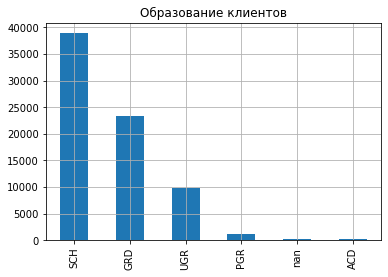

In [175]:
data_train['education'].astype('str').value_counts().plot(kind='bar', grid=True, title= 'Образование клиентов')

We can see that the most popular value in this column is school education. But, since there are also many people with higher education, let's assume that people with higher incomes have higher education. Let's create a function that assigns higher education to people with an income level higher than the third quintile, while the rest have a school education.


In [176]:
from functools import partial

def fill_edu(quan75, row):
    edu=row['education']
    if type(edu) is not str:
        if row['income'] > quan75:
            return 'GRD'
        else:
            return 'SCH'
        
    else:
        return edu
    


In [177]:
data_train['education']=data_train.apply(partial(fill_edu, data_train['income'].quantile(0.75)), axis=1)

In [178]:
data_test['education']=data_test.apply(partial(fill_edu, data_test['income'].quantile(0.75)), axis=1)

In [179]:
data_train.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
timedelta           0
dtype: int64

Grouping data of different types

In [180]:
bin_cols=['sex','car', 'car_type', 'foreign_passport', 'good_work'] #бинарные
cat_cols=['education', 'home_address', 'work_address'] # категориальные
num_cols=['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'timedelta'] # числовые
time_cols = ['app_date'] # временнЫе

In [181]:
def range_outliers(x):
    xmedian=x.median()
    xperc25=x.quantile(0.25)
    xperc75=x.quantile(0.75)
    xIQR=xperc75-xperc25
    print('median:{},'.format(xmedian),'25% percentile:{},'.format(xperc25), '75% percentile:{},'.format(xperc75), 'IQR:{},'.format(xIQR), 'limits of outliers: [{f},{l}]'.format(f=xperc25-1.5*xIQR, l=xperc75+1.5*xIQR))

Let's look at the distribution of numerical features:

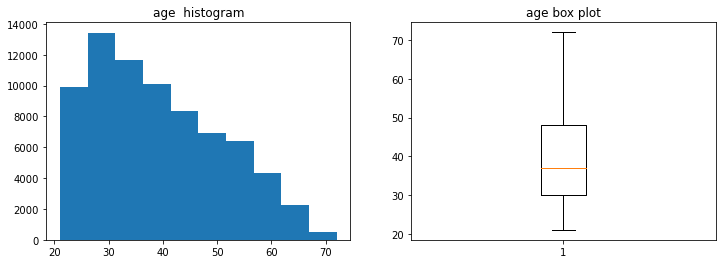

median:37.0, 25% percentile:30.0, 75% percentile:48.0, IQR:18.0, limits of outliers: [3.0,75.0]


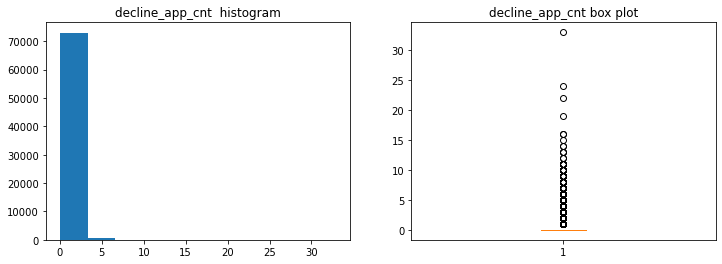

median:0.0, 25% percentile:0.0, 75% percentile:0.0, IQR:0.0, limits of outliers: [0.0,0.0]


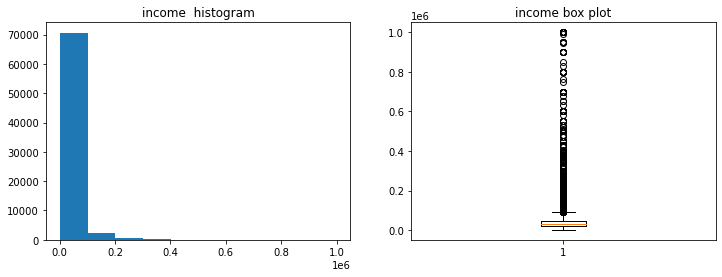

median:30000.0, 25% percentile:20000.0, 75% percentile:48000.0, IQR:28000.0, limits of outliers: [-22000.0,90000.0]


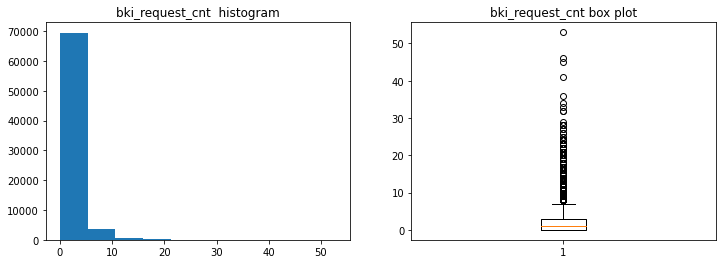

median:1.0, 25% percentile:0.0, 75% percentile:3.0, IQR:3.0, limits of outliers: [-4.5,7.5]


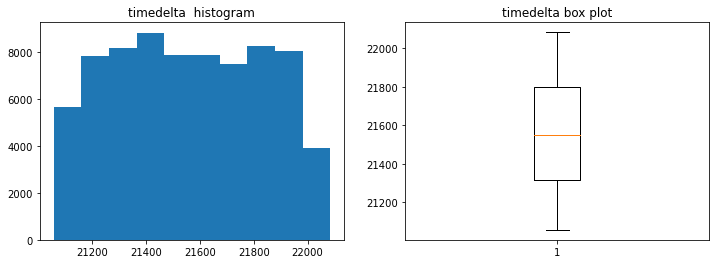

median:21548.16, 25% percentile:21314.88, 75% percentile:21798.72, IQR:483.84000000000015, limits of outliers: [20589.120000000003,22524.480000000003]


In [182]:
for i in num_cols:
    
    fig,axes=plt.subplots(1,2, figsize=(12,4))
    
    axes[0].hist(data_train[i])
    axes[0].set_title(i+ '  histogram')
    axes[1].boxplot(data_train[i])
    axes[1].set_title(i+ ' box plot')
    plt.show()
    range_outliers(data_train[i])

After plotting the histograms, it became obvious that the distributions of all numerical variables, except for 'timedelta', have a heavy right tail. To obtain a more uniform distribution, we take the logarithm of the features. And let's see how the graphs change

C:\Users\trigu\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


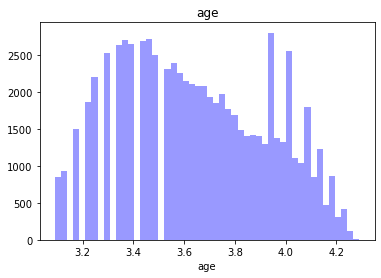

C:\Users\trigu\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


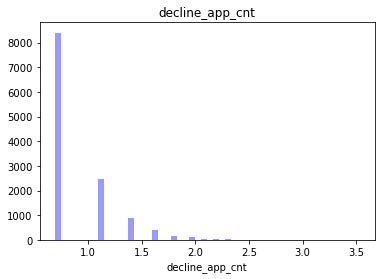

C:\Users\trigu\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


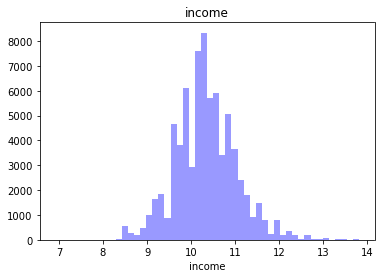

C:\Users\trigu\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


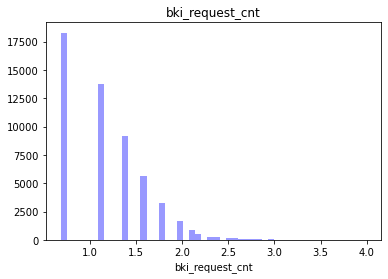

C:\Users\trigu\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


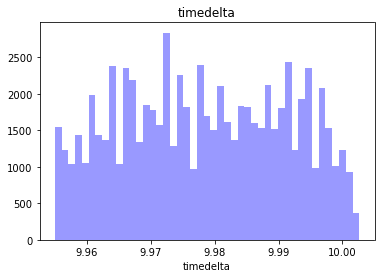

In [183]:
for i in num_cols:
    data_train[i] = np.log(data_train[i] + 1)
    plt.figure()
    sns.distplot(data_train[i][data_train[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

In [184]:
data_train.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,timedelta
0,25905,2014-02-01,SCH,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,N,0,9.990445
1,63161,2014-03-12,SCH,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,N,0,9.974879
2,25887,2014-02-01,SCH,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,Y,0,9.990445


# Correlation of numerical features

In [185]:
correlation=data_train[num_cols].corr()
correlation

,age,decline_app_cnt,income,bki_request_cnt,timedelta
age,1.000000,-0.127734,-0.092586,0.049327,-0.017087
decline_app_cnt,-0.127734,1.000000,-0.013868,0.125163,0.022722
income,-0.092586,-0.013868,1.000000,0.081019,-0.005260
bki_request_cnt,0.049327,0.125163,0.081019,1.000000,0.009672
timedelta,-0.017087,0.022722,-0.005260,0.009672,1.000000


<AxesSubplot:>

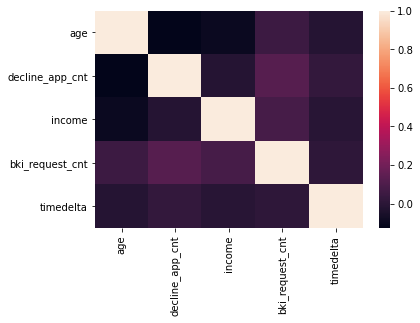

In [186]:
sns.heatmap(correlation)

We see only a weak correlation between 'decline_app_cnt' and 'bki_request_cnt'. For further evaluation, we will check the significance of these features.

### Binary features

Let's convert the values of binary features to zeros and ones

In [187]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data_train[column] = label_encoder.fit_transform(data_train[column])
    data_test[column] = label_encoder.fit_transform(data_test[column])

The distribution of values in binary features

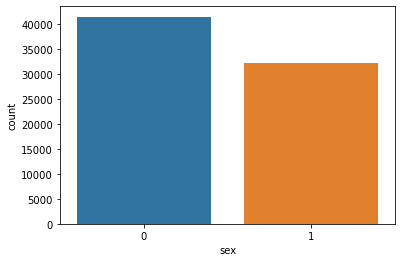

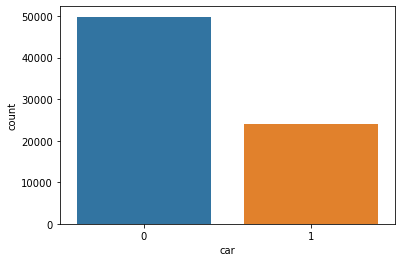

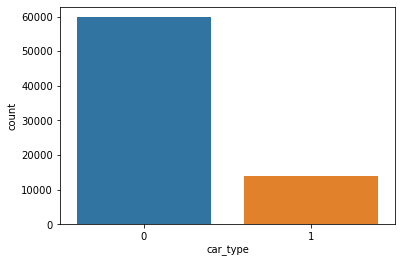

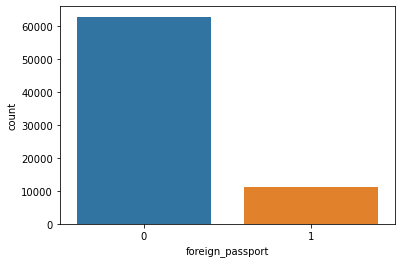

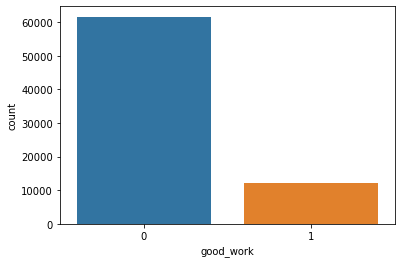

In [188]:
for column in data_train[bin_cols]:
    bin_cal_val=data_train[column].value_counts()
    #bin_cal_val.plot(kind='bar', title=column)
    sns.countplot(x=data_train[column], data=data_train[bin_cols])
    plt.show()

### Categorical Features

In [ ]:
encoder=OneHotEncoder(sparse=False)

train_X_encoded = pd.DataFrame (encoder.fit_transform(train_X[['Sex']]))

train_X_encoded.columns = encoder.get_feature_names(['Sex'])

train_X.drop(['Sex'] ,axis=1, inplace=True)

OH_X_train= pd.concat([train_X, train_X_encoded ], axis=1)

In [213]:
oh_encoder=OneHotEncoder(sparse=False)
X_cat = pd.DataFrame(oh_encoder.fit_transform(data_train[cat_cols].values))
X_cat_test = pd.DataFrame(oh_encoder.fit_transform(data_test[cat_cols].values))

In [221]:
cat_col_names = oh_encoder.get_feature_names()
cat_col_names = cat_col_names.tolist()

### Let's combine the prepared data into one set

In [194]:
X=np.hstack([X_num_train, data_train[bin_cols].values, X_cat_train])
X_Test = np.hstack([X_num_test, data_test[bin_cols].values, X_cat_test])
y=data_train['default'].values

### Standardizing features

In [196]:
X =StandardScaler().fit_transform(X)
X_num_test =StandardScaler().fit_transform(X_Test)

### Assessment of the significance of features

To assess the significance of numerical variables, we will use the f_classif function from the sklearn library.

In [199]:
f_classif(X, y)

(array([  50.3805738 , 1152.93731744,  214.79052738,  457.59176046,
         115.02245779,   28.41465738,  137.73286531,  244.66329744,
         329.96184694,  139.01130278,   12.90457444,  428.27367014,
          45.16139373,  417.43376759,    2.092296  ,  617.00462595,
         628.13675939,    1.38067054,  237.35378196,  153.89567255,
         458.85750261]),
 array([1.27778005e-012, 8.96214001e-251, 1.44923018e-048, 3.26668129e-101,
        8.14373905e-027, 9.82078995e-008, 8.89796288e-032, 4.64013412e-055,
        1.41830731e-073, 4.67979108e-032, 3.27992997e-004, 7.18943232e-095,
        1.82759849e-011, 1.59458636e-092, 1.48047678e-001, 1.21350806e-135,
        4.82075470e-138, 2.39990755e-001, 1.79935229e-053, 2.64713467e-035,
        1.73922960e-101]))

In [222]:
col_names = num_cols + bin_cols + cat_col_names

<AxesSubplot:title={'center':'significance of numerical features'}>

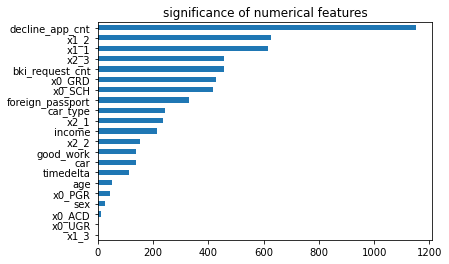

In [223]:
imp = pd.Series(f_classif(X, y)[0], index = col_names)
imp.sort_values(inplace = True)
imp.plot(kind = 'barh', title='significance of numerical features')

'decline_app_cnt' is the most significant attribute

### Divide the sample into training and test 

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Let's write a function for training and testing a model that returns the completed model

In [236]:
def trait_regressor(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print('Accuracy:'+str(accuracy_score(y_test, y_pred)))
    print('Precision:'+str(precision_score(y_test, y_pred)))
    print('Recall:'+str(recall_score(y_test, y_pred)))
    print('f1: ' + str(f1_score(y_test, y_pred)))
    
    fig = plt.figure(figsize=(6, 6))
    cm1 = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm1, annot = True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    cm1
    
    return model

Let's start with logistic regression

Accuracy:0.8760840108401085
Precision:0.4375
Recall:0.0038314176245210726
f1: 0.00759631036353771


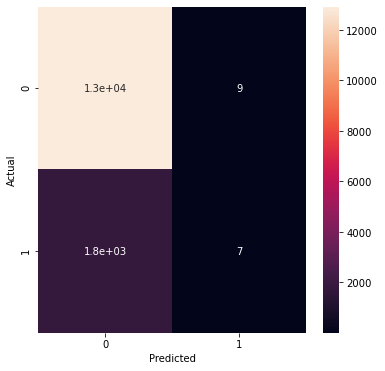

In [237]:
lr = trait_regressor(X_train, y_train, X_test, y_test, LogisticRegression(max_iter=1000, random_state = RANDOM_SEED))

Accuracy:0.8705284552845528
Precision:0.2878787878787879
Recall:0.031198686371100164
f1: 0.056296296296296296


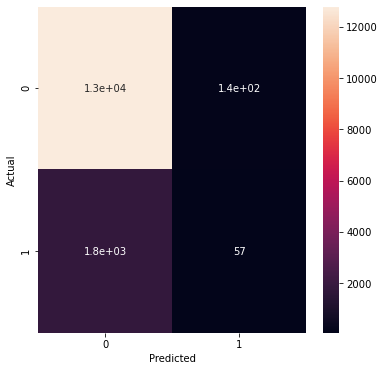

In [242]:
rf = trait_regressor(X_train, y_train, X_test, y_test,
                            RandomForestClassifier(random_state = RANDOM_SEED)
                       )

In [ ]:
svc = trait_regressor(X_train, y_train, X_test, y_test,
                            SVC(random_state = RANDOM_SEED)
                       )

Accuracy:0.8756775067750677
Precision:0.16666666666666666
Recall:0.0010946907498631637
f1: 0.0021750951604132683


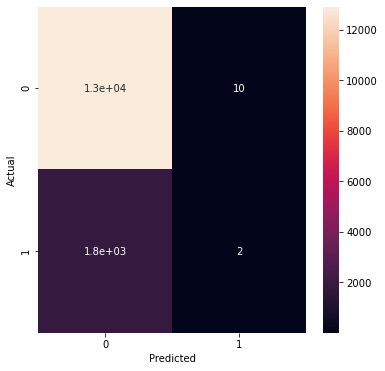

In [244]:
gb = trait_regressor(X_train, y_train, X_test, y_test,
                            GradientBoostingClassifier(random_state = RANDOM_SEED)
                       )

Accuracy:0.8748644986449865
Precision:0.2222222222222222
Recall:0.004378762999452655
f1: 0.008588298443370907


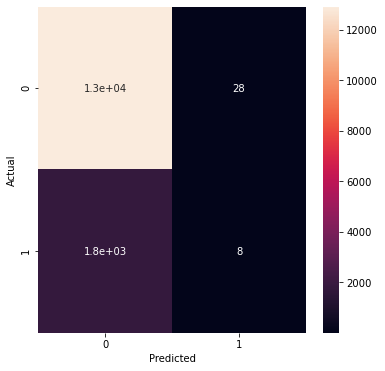

In [249]:
# {'max_depth': 6, 'n_estimators': 500}
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 4, 6]
}
gb_best = trait_regressor( X_train, y_train, X_test, y_test,
                       GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, n_jobs = 6)
                       )


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel="poly", probability=True, random_state=0)
model_svc = svc.fit(X_train, y_train)
probs= model_svc.predict(X_test)
print('Accuracy:'+str(accuracy_score(y_test, probs)))

In [ ]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_2)))
print('Precision:'+str(precision_score(y_test, y_pred_2)))
print('Recall:'+str(recall_score(y_test, y_pred_2)))
print('f1: ' + str(f1_score(y_test, y_pred_2)))

In [ ]:
fig = plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm2, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm2

Подстановка гиперпараметров не смогла улучшить ситуацию

Возможно, проблемой является несбалансированность выборки по целевой переменной.

In [ ]:
sns.countplot(x=data_train['default'], data=data_train)

Попробуем для тренировочной выборки сократить количество недефолтных клиентов, реализуя таким образом undersampling. 

In [ ]:
data_reduced_def_0=data_train[:15000][(data_train['default']==0)]
data_reduced_def_0.head(3)


In [ ]:
data_reduced_def_1=data_train[(data_train['default']==1)]
data_reduced_def_1.head(3)

In [ ]:
data_reduced=data_reduced_def_0.append(data_reduced_def_1)
data_reduced.head(3)

таким образом мы сократили выборку, но сделали ее более сбалансированной по целевой переменной.

In [ ]:
sns.countplot(x=data_reduced['default'], data=data_reduced)  


In [ ]:

#data_reduced=data_reduced.drop(['age', 'sex', 'client_id', 'app_date'], axis=1)


Попробуем избавиться от выбросов для некоторых числовых признаков

In [ ]:
range_outliers(data_reduced['income'])

In [ ]:

#range_outliers(data_reduced['bki_request_cnt'])

In [ ]:
#data_reduced=data_reduced[(data_reduced['income']<11.93)& (data_reduced['bki_request_cnt']<3.46)]
#data_reduced.head(3)

In [ ]:
#bin_cols=['car', 'car_type', 'foreign_passport', 'good_work'] #бинарные
#cat_cols=['education', 'home_address', 'work_address'] # категориальные
#num_cols=[ 'decline_app_cnt', 'income', 'bki_request_cnt', 'timedelta'] # числовые
#time_cols = ['app_date'] # временнЫе

In [ ]:
for column in bin_cols:
    data_reduced[column] = label_encoder.fit_transform(data_reduced[column])

In [ ]:
for column in num_cols:
    data_reduced[column] = np.log(data_reduced[column] + 1)
data_reduced.head(3)   

In [ ]:
X_cat_reduced = OneHotEncoder(sparse = False).fit_transform(data_reduced[cat_cols].values)

In [ ]:
X_num_reduced =StandardScaler().fit_transform(data_reduced[num_cols].values)

In [ ]:
X_num_reduced

In [ ]:
X_reduced=np.hstack([X_num_reduced, data_reduced[bin_cols].values, X_cat_reduced])


y_reduced=data_reduced['default'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
model_3 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.0, penalty= 'l2', class_weight =None,
                           dual = False, fit_intercept =True, intercept_scaling = 1,
                          l1_ratio = None, max_iter = 1000,  n_jobs = None, tol = 0.0001, verbose = 0,warm_start = False,)

model_3.fit(X_train, y_train)

In [ ]:
y_pred_reduced=model_3.predict(X_test)

In [ ]:
probs_3 = model_3.predict_proba(X_test)
probs_3 = probs_3[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_3)
roc_auc = roc_auc_score(y_test, probs_3)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_reduced)))
print('Precision:'+str(precision_score(y_test, y_pred_reduced)))
print('Recall:'+str(recall_score(y_test, y_pred_reduced)))
print('f1: ' + str(f1_score(y_test, y_pred_reduced)))

In [ ]:
fig = plt.figure(figsize=(6, 6))
cm3 = confusion_matrix(y_test, y_pred_reduced)
sns.heatmap(cm2, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm3

В результате уменьшения выборки с целью её сбалансирования наша f1-score существенно увеличился. При чем чем сильнее я урезала выборку до более сбалансированной тем больше становился он становился. 
Площать под кривой всё равно ROC AUC уменшилась. 

Воспользуемся методом coef_ для определения значимости признаков

In [ ]:
importance = model_3.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Исходя из этого мы можем попробовать убрать фичи с наименьшим влиянием

In [ ]:
X_reduced_4=np.delete(X_reduced, [6, 19],1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_4, y_reduced, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
model_4 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.0, penalty= 'l2', class_weight =None,
                           dual = False, intercept_scaling = 1,
                          l1_ratio = None, max_iter = 1000,  n_jobs = None, tol = 0.0001, verbose = 0,warm_start = False,)

model_4.fit(X_train, y_train)

In [ ]:
y_pred_4=model_4.predict(X_test)


In [ ]:
probs_4 = model_4.predict_proba(X_test)
probs_4 = probs_4[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_4)
roc_auc = roc_auc_score(y_test, probs_4)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_4)))
print('Precision:'+str(precision_score(y_test, y_pred_4)))
print('Recall:'+str(recall_score(y_test, y_pred_4)))
print('f1: ' + str(f1_score(y_test, y_pred_4)))

In [ ]:
fig = plt.figure(figsize=(6, 6))
cm4 = confusion_matrix(y_test, y_pred_4)
sns.heatmap(cm2, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm4

 При удаление фич с наименьшим влиянием f1-score стал меньше

Для сбалансированности мы значительно уменьшили выборку потеряв много ценных данных. Это улучшило результат. Попробуем добавить к нашему датасэту контрольный сет.  

In [ ]:
y_pred_prob = model_3.predict_proba(X_Test)[:,1]


submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [ ]:
#submission_pred_prob = model_3.predict_proba(X_Test)[:,1]
#submission_predict = model_3.predict(X_Test)

#submission = pd.DataFrame({'client_id': data_test['client_id'].values, 
                            #'default': submission_pred_prob})
#submission.to_csv('submission.csv', index=False)

#submission